### Učitavanje potrebnih biblioteka

In [68]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, roc_curve, auc
import os
import shutil
import random
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tqdm.notebook import tqdm


### Učitavanje seta podataka

In [69]:
class FaceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [70]:
main_data_folder = './data/people/'
train_folder = './data/train/'
valid_folder = './data/valid/'

# Remove existing folders (if they exist)
for folder in [train_folder, valid_folder]:
    if os.path.exists(folder):
        shutil.rmtree(folder)

# Create destination folders
for folder in [train_folder, valid_folder]:
    os.makedirs(folder, exist_ok=True)

for class_name in os.listdir(main_data_folder):
    class_path = os.path.join(main_data_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)

    os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_folder, class_name), exist_ok=True)

    valid_images = images[:20]
    train_images = images[20:]

    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_folder, class_name, img))
    for img in valid_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(valid_folder, class_name, img))

    print(f"Class {class_name}: {len(train_images)} train, {len(valid_images)} validation images.")

Class Angelina Jolie: 80 train, 20 validation images.
Class Brad Pitt: 80 train, 20 validation images.
Class Denzel Washington: 80 train, 20 validation images.
Class Hugh Jackman: 80 train, 20 validation images.
Class Jennifer Lawrence: 80 train, 20 validation images.
Class Johnny Depp: 80 train, 20 validation images.
Class Kate Winslet: 80 train, 20 validation images.
Class Leonardo DiCaprio: 80 train, 20 validation images.
Class Megan Fox: 80 train, 20 validation images.
Class Natalie Portman: 80 train, 20 validation images.
Class Nicole Kidman: 80 train, 20 validation images.
Class Robert Downey Jr: 80 train, 20 validation images.
Class Sandra Bullock: 80 train, 20 validation images.
Class Scarlett Johansson: 180 train, 20 validation images.
Class Tom Cruise: 80 train, 20 validation images.
Class Tom Hanks: 80 train, 20 validation images.
Class Will Smith: 80 train, 20 validation images.


In [71]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [72]:
train_dataset = FaceDataset(train_folder, transform=train_transform)
val_dataset = FaceDataset(valid_folder, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


### Treniranje modela

In [73]:
num_classes = len(train_dataset.classes)

model = torchvision.models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor

# Replace classifier
model.avgpool = nn.AdaptiveAvgPool2d((7, 7))
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512 * 7 * 7, 256),  # Add intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

C:\Users\Vedran\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Vedran\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training loop

In [75]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

train_losses, val_losses = [], []
best_val_loss = float('inf')

os.makedirs('./models/', exist_ok=True)

while True:
    try:
        num_epochs = int(input("How many epochs would you like to train for? (Enter 0 to stop): "))
        if num_epochs <= 0:
            print("Training stopped by user.")
            break

        for epoch in range(1, num_epochs + 1):
            # Training phase
            model.train()
            running_loss = 0.0
            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch} - Training loop'):
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * labels.size(0)
            
            train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            running_loss = 0.0
            with torch.no_grad():
                for images, labels in tqdm(val_loader, desc=f'Epoch {epoch} - Validation loop'):
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item() * labels.size(0)
            
            val_loss = running_loss / len(val_loader.dataset)
            val_losses.append(val_loss)

            print(f"Epoch {epoch}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            model_path = f"./models/model_{timestamp}.pth"
            torch.save(model.state_dict(), model_path)
            print(f"New model saved at {model_path}")

            scheduler.step(val_loss)

        print(f"Completed {num_epochs} epochs.")
    
    except ValueError:
        print("Invalid input. Please enter a valid number.")

Training stopped by user.


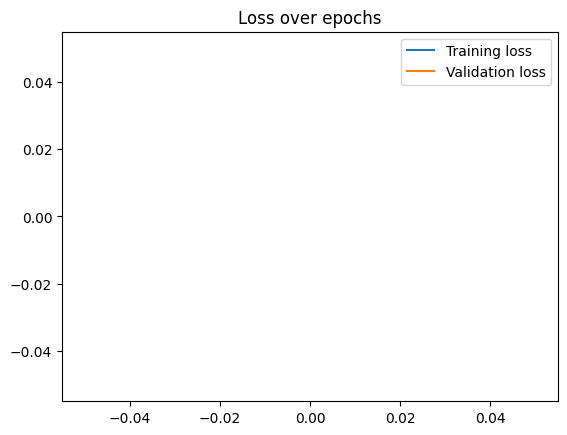

In [76]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

### Evaluacija modela

In [101]:
#Load model from file
num_classes = len(train_dataset.classes)

model = torchvision.models.vgg16(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor

# Replace classifier
model.avgpool = nn.AdaptiveAvgPool2d((7, 7))
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512 * 7 * 7, 256),  # Add intermediate layer
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)
model.load_state_dict(torch.load('./best_model.pth'))
model.to(device)

C:\Users\Vedran\AppData\Local\Temp\ipykernel_4792\595277808.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./best_model.pth'))


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [95]:
# Model evaluation
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy()[:, 1])
        all_labels.extend(labels.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs, pos_label=1)
roc_auc = auc(fpr, tpr)

# Calculate the Equal Error Rate (EER)
fnr = 1 - tpr  # False Negative Rate
eer_idx = np.nanargmin(np.abs(fnr - fpr))  # Find the threshold where FPR is closest to FNR
eer = fpr[eer_idx]
eer_threshold = thresholds[eer_idx]

# Calculate accuracy at the threshold where EER occurs
predicted_labels = (all_probs >= eer_threshold).astype(int)
accuracy = accuracy_score(all_labels, predicted_labels)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.scatter([fpr[eer_idx]], [tpr[eer_idx]], color='red', label=f"EER: {eer:.2f}", zorder=5)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print EER, threshold, and accuracy
print(f"Equal Error Rate (EER): {eer:.2f}")
print(f"Threshold at EER: {eer_threshold:.2f}")
print(f"Accuracy at EER Threshold: {accuracy:.2f}")


Testing:   0%|          | 0/22 [00:00<?, ?it/s]

KeyboardInterrupt: 

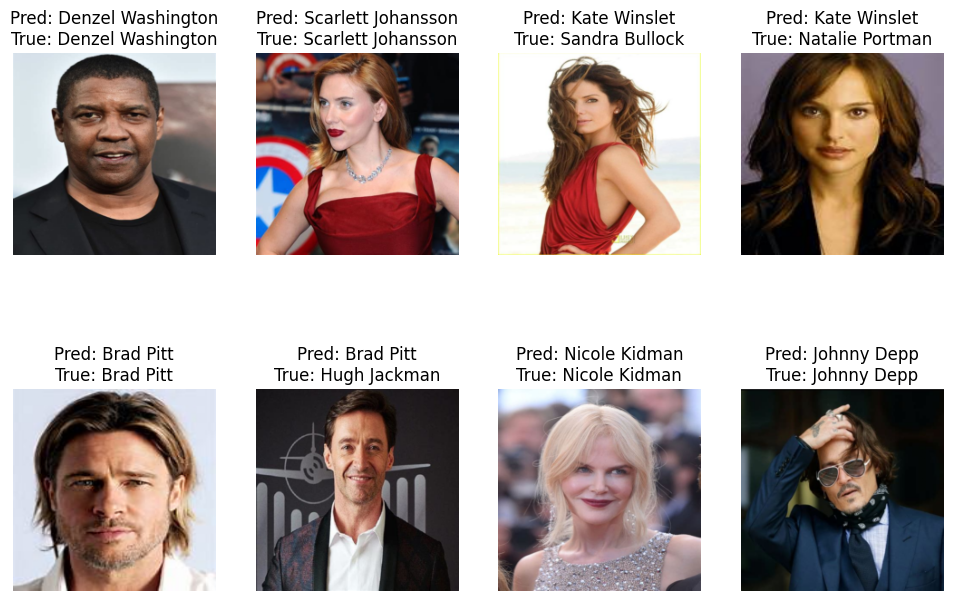

In [103]:
# Display some random test images with predictions
def imshow(image, title):
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

# Get 8 random indices from the dataset
random_indices = random.sample(range(len(val_dataset)), 8)

# Create a Subset dataset with these indices
random_subset = torch.utils.data.Subset(val_dataset, random_indices)
random_loader = torch.utils.data.DataLoader(random_subset, batch_size=8, shuffle=False)

# Get the random batch of images
images, labels = next(iter(random_loader))

images = images.to(device)

# Get predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Display random images with predictions
plt.figure(figsize=(12, 8))
for i in range(len(images)):
    plt.subplot(2, 4, i + 1)
    imshow(images[i].cpu(), title=f"Pred: {val_dataset.classes[preds[i]]}\nTrue: {val_dataset.classes[labels[i]]}")
plt.show()
